# DenseNet169StackingANNVMLR
The purpose of this study is to classify bone marrow changes in the lumbar vertebrae using magnetic resonance imaging (MRI) and evaluate the effectiveness of a proposed hybrid model for accurate diagnosis. Bone marrow changes in the lumbar spine are commonly associated with various conditions, including degenerative diseases, chronic low back pain (CLBP), and other pathological processes. Accurate identification of these changes is crucial for early diagnosis and appropriate treatment planning

Traditional methods of analyzing MRI scans are often time-consuming and prone to subjective interpretation. Therefore, there is a need for automated, robust, and efficient techniques to improve diagnostic accuracy. In response to this need, we propose a hybrid model that leverages DenseNet169 as a feature extractor, followed by a stacking ensemble of Artificial Neural Networks (ANN), Support Vector Machines (SVM), and Logistic Regression (LR) classifiers. The model, named DenseNet169StackingANNVMLR, aims to enhance classification performance by combining the strengths of these machine learning techniques.

This study investigates the classification performance of the DenseNet169StackingANNVMLR model for detecting and categorizing bone marrow changes in the lumbar vertebrae using MRI data. By employing advanced deep learning and machine learning techniques, we aim to develop a reliable, automated system that could support radiologists and clinicians in diagnosing bone marrow abnormalities with higher precision.



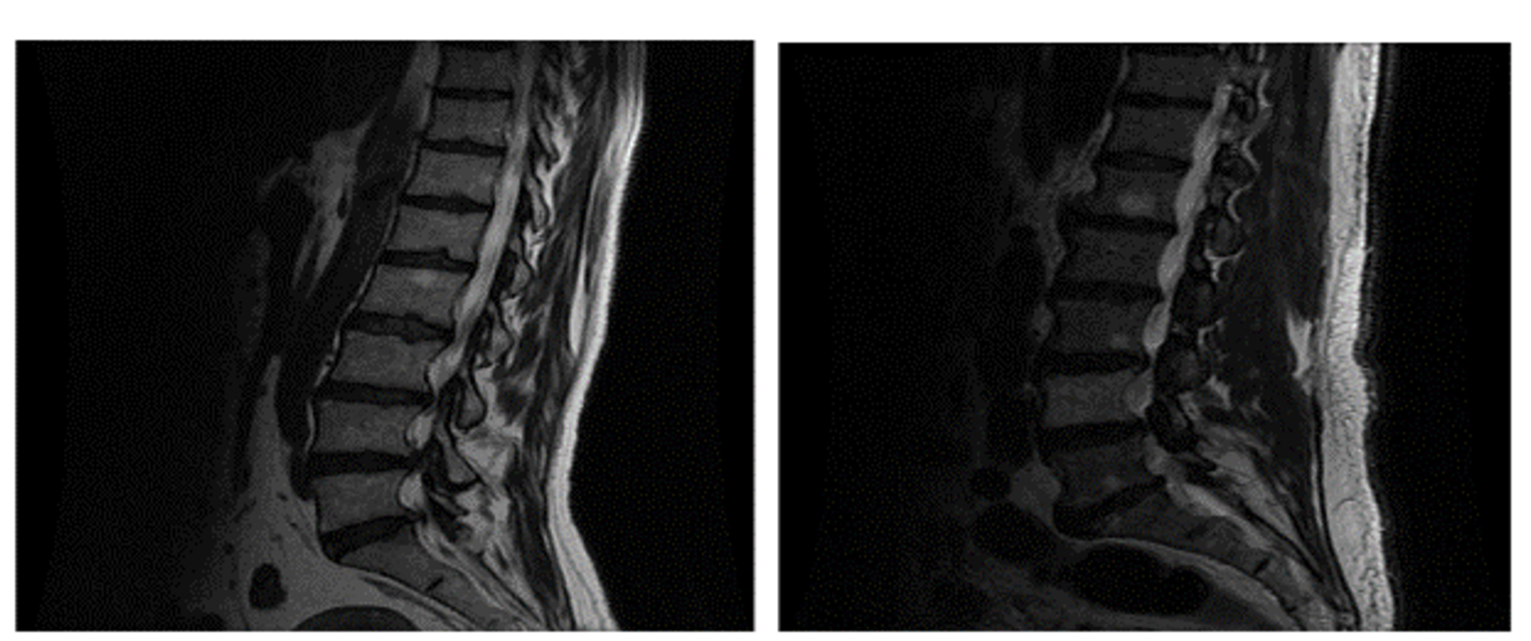

In [1]:
pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
Note:

In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications import DenseNet169
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:

# Paths to the directories
normal_dir = '/kaggle/input/bone-without/bone/Normal'
abnormal_dir = '/kaggle/input/bone-without/bone/Abnormal'

# Step 1: Data Loading and Preprocessing
def load_images_from_directory(directory, target_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            img = img / 255.0  # Normalize
            images.append(img)
            # Label: 0 for Normal, 1 for Abnormal
            label = 0 if 'Normal' in directory else 1
            labels.append(label)
    return np.array(images), np.array(labels)

#Load the images
normal_images, normal_labels = load_images_from_directory(normal_dir)
abnormal_images, abnormal_labels = load_images_from_directory(abnormal_dir)

#Combine all images and labels
X = np.concatenate([normal_images, abnormal_images], axis=0)
y = np.concatenate([normal_labels, abnormal_labels], axis=0)

#DenseNet169 Model Architecture (Feature Extractor)
def build_feature_extractor(input_shape=(224, 224, 3)):
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Model(inputs=base_model.input, outputs=base_model.output)
    return model

feature_extractor = build_feature_extractor()

#Extract Deep Features
def extract_deep_features(images, model):
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)

#Extract deep features
deep_features = extract_deep_features(X, feature_extractor)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1729782592.748548     105 service.cc:145] XLA service 0x798a240065a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729782592.748606     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729782592.748611     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step  

I0000 00:00:1729782608.415588     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 689ms/step


In [4]:
deep_features

array([[0.        , 0.00665013, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00645808, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00691492, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00682127, 0.        , ..., 0.24587712, 0.        ,
        0.        ],
       [0.        , 0.00659067, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00711149, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [5]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(deep_features, y, test_size=0.2, random_state=42)

In [6]:
#Define Classifiers (ANN)
def build_ann(input_dim):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_dim))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # Binary classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
from tensorflow import keras
# Wrap the Keras model with KerasClassifier from scikeras
ann = KerasClassifier(model=build_ann, input_dim=X_train.shape[1], epochs=30, batch_size=32, verbose=0)

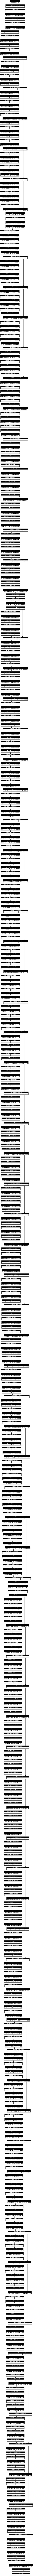

In [8]:
from tensorflow.keras.utils import plot_model
# Visualize the Feature Extractor (DenseNet169)
feature_extractor = build_feature_extractor()
#plot_model(feature_extractor, to_file='feature_extractor.png', show_shapes=True, show_layer_names=True)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


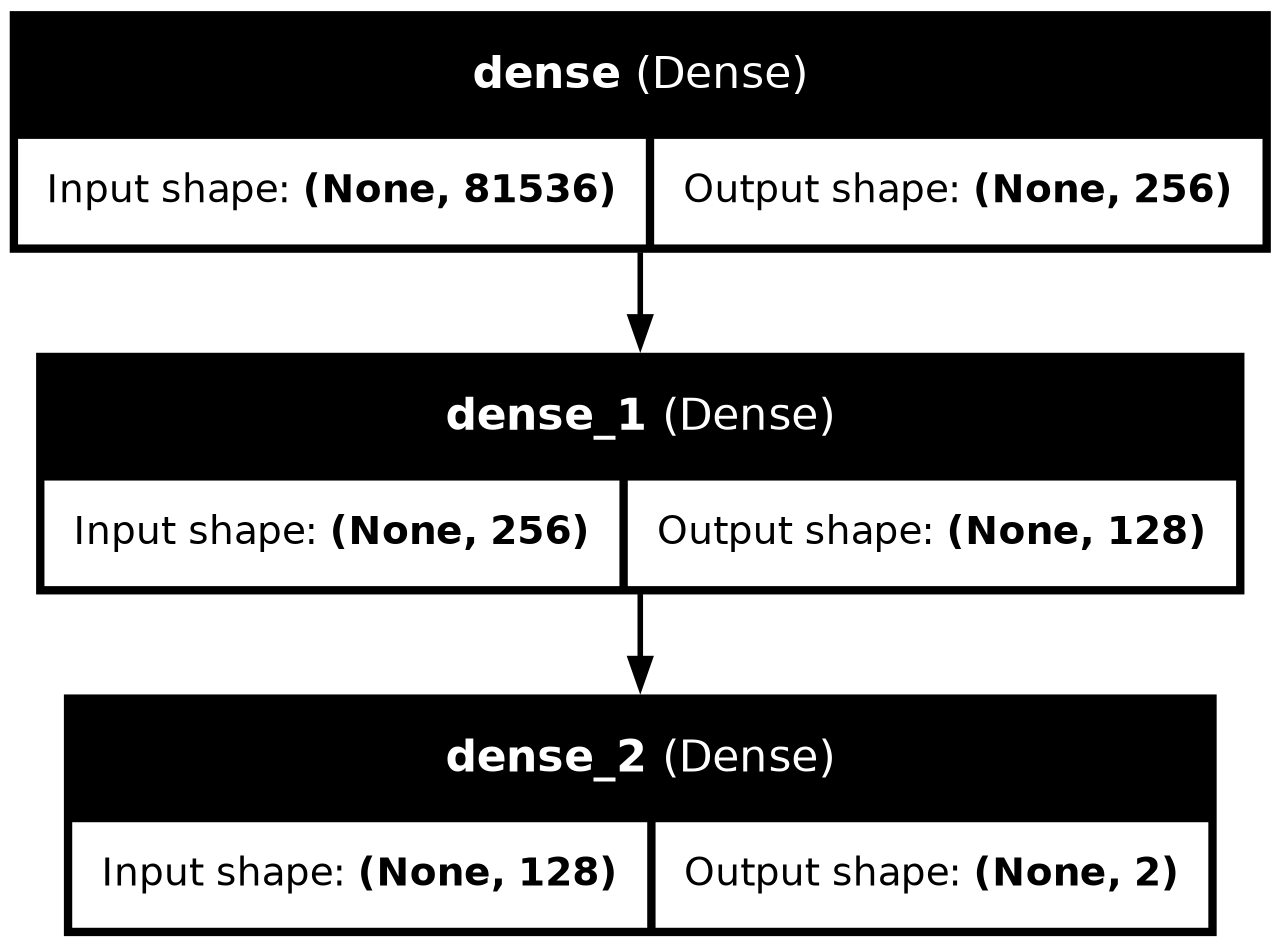

In [9]:
# Visualize the ANN Classifier
ann_model = build_ann(input_dim=X_train.shape[1])
plot_model(ann_model, to_file='ann_classifier.png', show_shapes=True, show_layer_names=True)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        88
           1       0.92      0.93      0.92       116

    accuracy                           0.91       204
   macro avg       0.91      0.91      0.91       204
weighted avg       0.91      0.91      0.91       204

Accuracy: 0.9118
Precision: 0.9153
Recall: 0.9310
F1 Score: 0.9231
Confusion Matrix:
[[ 78  10]
 [  8 108]]


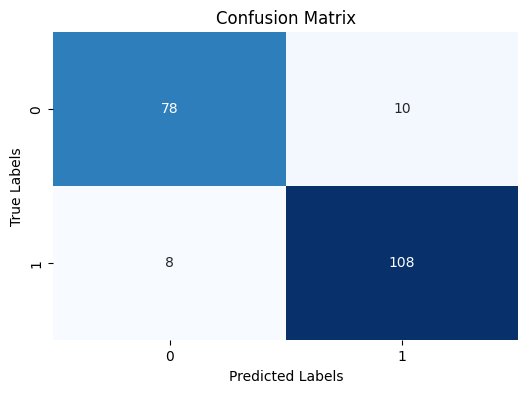

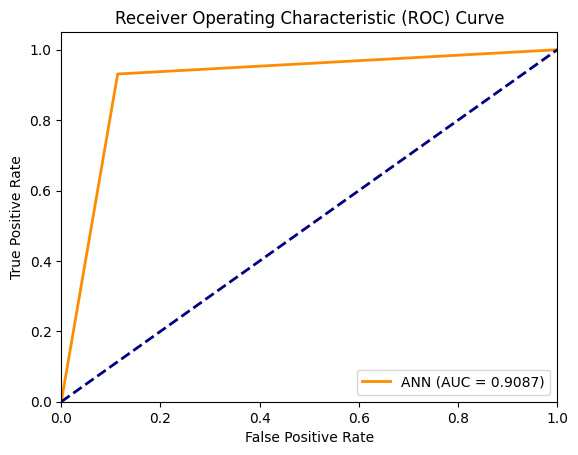

In [10]:
# Train ANN 
ann.fit(X_train, y_train)

# Make predictions with ANN
y_pred_ann = ann.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_ann))

# Print accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred_ann)
precision = precision_score(y_test, y_pred_ann)
recall = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrixann = confusion_matrix(y_test, y_pred_ann)
print("Confusion Matrix:")
print(conf_matrixann)


# Plot Confusion Matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrixann, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC Curve and AUC
# Compute ROC curve and ROC area
fpr_ann, tpr_ann, thresholds = roc_curve(y_test, y_pred_ann)
roc_auc_ann = auc(fpr_ann, tpr_ann)

# Plot ROC curve
plt.figure()

plt.plot(fpr_ann, tpr_ann, color='darkorange', lw=2, label=f'ANN (AUC = {roc_auc_ann:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save the ANN model
ann.model_.save('ann_model.keras')

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        88
           1       0.93      0.91      0.92       116

    accuracy                           0.91       204
   macro avg       0.91      0.91      0.91       204
weighted avg       0.91      0.91      0.91       204

Accuracy: 0.9118
Precision: 0.9298
Recall: 0.9138
F1 Score: 0.9231
Confusion Matrix:
[[ 80   8]
 [ 10 106]]


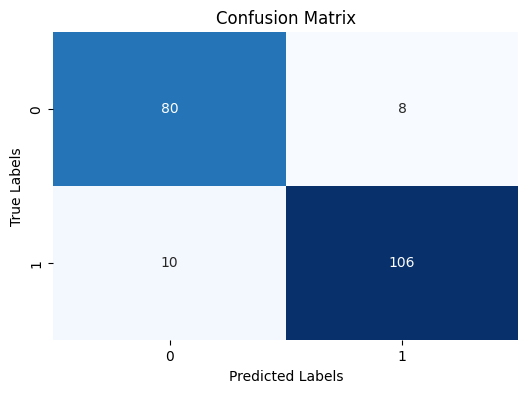

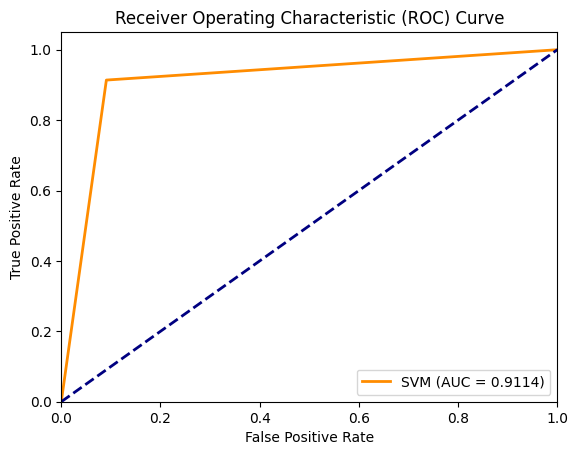

In [12]:
# Train svm separately
svm = SVC(kernel='linear', probability=True)

svm.fit(X_train, y_train)

# SVM is already trained, make predictions
y_pred_svm = svm.predict(X_test)



# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Print accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_ann)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)

# Plot Confusion Matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute ROC curve and ROC area
fpr_svm, tpr_svm, thresholds = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        88
           1       0.91      0.91      0.91       116

    accuracy                           0.90       204
   macro avg       0.90      0.90      0.90       204
weighted avg       0.90      0.90      0.90       204

Accuracy: 0.9020
Precision: 0.9138
Recall: 0.9138
F1 Score: 0.9138
Confusion Matrix:
[[ 78  10]
 [ 10 106]]


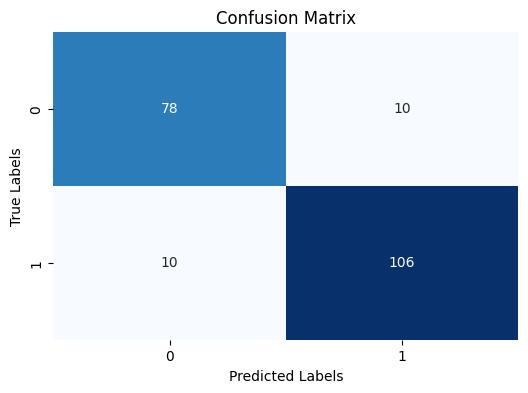

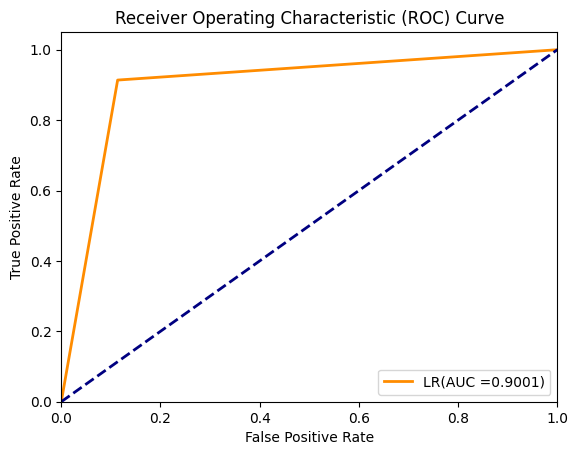

In [13]:
# Train LogisticRegression 
lr = LogisticRegression(max_iter=300)

lr.fit(X_train, y_train)

# SVM is already trained, make predictions
y_pred_lr = lr.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Print accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(conf_matrix_lr)

# Plot Confusion Matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute ROC curve and ROC area
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'LR(AUC ={roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/co

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91        88
           1       0.93      0.94      0.94       116

    accuracy                           0.93       204
   macro avg       0.93      0.92      0.92       204
weighted avg       0.93      0.93      0.93       204

Accuracy: 0.9265
Precision: 0.9316
Recall: 0.9397
F1 Score: 0.9356
Confusion Matrix:
[[ 80   8]
 [  7 109]]


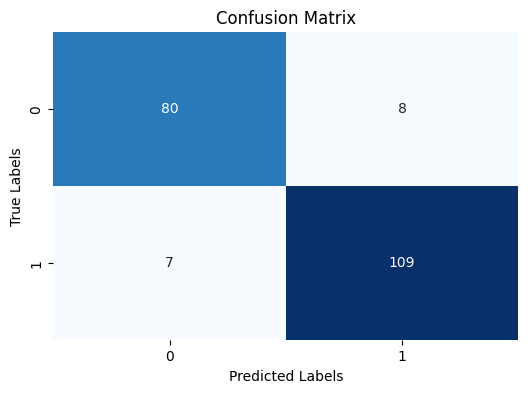

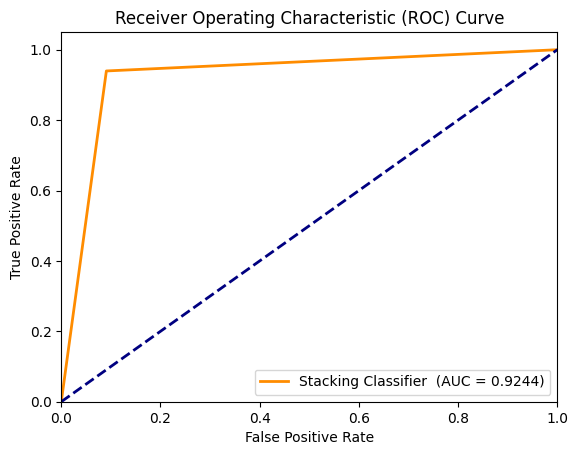

In [19]:
# Stacking Classifier
estimators = [
    ('ann', ann),
    ('svm', svm),
    ('lr', lr)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)

# Model Evaluation
y_pred_stacking = stacking_model.predict(X_test)
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_stacking))

# Print accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred_stacking)
precision = precision_score(y_test, y_pred_stacking)
recall = recall_score(y_test, y_pred_stacking)
f1 = f1_score(y_test, y_pred_stacking)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
print("Confusion Matrix:")
print(conf_matrix_stacking)


# Plot Confusion Matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_stacking, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute ROC curve and ROC area
fpr_stacking, tpr_stacking, thresholds = roc_curve(y_test, y_pred_stacking)
roc_auc_stacking = auc(fpr_stacking, tpr_stacking)

# Plot ROC curve
plt.figure()
plt.plot(fpr_stacking, tpr_stacking, color='darkorange', lw=2, label=f'Stacking Classifier  (AUC = {roc_auc_stacking:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
stacking_model

StackingClassifier(estimators=[('ann',
                                KerasClassifier(batch_size=32, epochs=30, input_dim=81536, model=<function build_ann at 0x798a90241cf0>, verbose=0)),
                               ('svm', SVC(kernel='linear', probability=True)),
                               ('lr', LogisticRegression(max_iter=300))],
                   final_estimator=LogisticRegression())

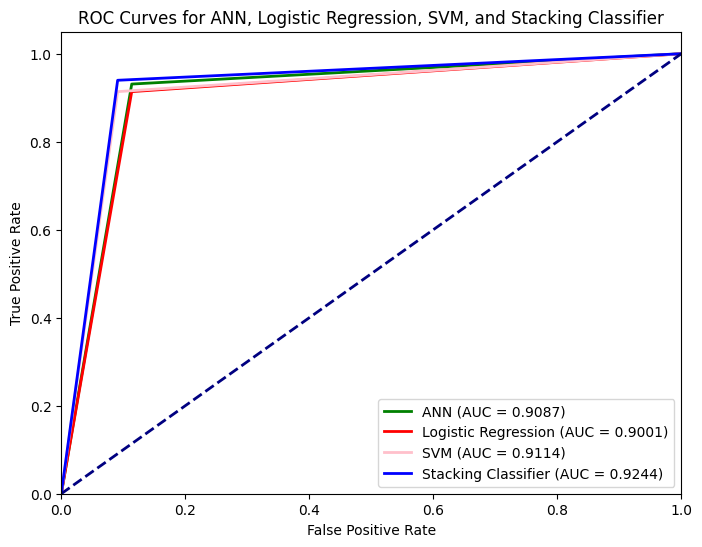

In [30]:
import matplotlib.pyplot as plt


# Plot ROC curves for all models
plt.figure(figsize=(8, 6))


# ANN ROC curve
plt.plot(fpr_ann, tpr_ann, color='green', lw=2, label=f'ANN (AUC = {roc_auc_ann:.4f})')

# Logistic Regression ROC curve
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# SVM ROC curve
plt.plot(fpr_svm, tpr_svm, color='pink', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')

# Stacking Classifier ROC curve
plt.plot(fpr_stacking, tpr_stacking, color='blue', lw=2, label=f'Stacking Classifier (AUC = {roc_auc_stacking:.4f})')

#plt.plot(fpr_stacking, tpr_stacking, color='darkorange', lw=2, label=f'HYBRID = {roc_auc_stacking:.2f})')

# Plot random classifier (diagonal line)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)

# Configure the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ANN, Logistic Regression, SVM, and Stacking Classifier')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [ ]:
# Save the SVM and Logistic Regression models using joblib
import joblib
joblib.dump(svm, 'svm.pkl')
joblib.dump(lr, 'lr.pkl')
joblib.dump(stacking_model, 'stacking_model.pkl')